# Sea Surface Temperature Reconstruction - Training and evaluation

See Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of this model.

Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.

In this notebook we compare the performance of the model with L4 reconstruction.


In [16]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import gdown

loading the residual dataset

In [2]:
!gdown 1CckeQ7Nre4UpITPgWYXI-HF_Le8MtFMh #date

Downloading...
From: https://drive.google.com/uc?id=1CckeQ7Nre4UpITPgWYXI-HF_Le8MtFMh
To: /content/time_l3s.npy
100% 62.9k/62.9k [00:00<00:00, 51.2MB/s]


In [3]:
!gdown 1KJdhGzDx-zKZzMIQv4PzWdk8DPa2w--r #climatology

Downloading...
From (original): https://drive.google.com/uc?id=1KJdhGzDx-zKZzMIQv4PzWdk8DPa2w--r
From (redirected): https://drive.google.com/uc?id=1KJdhGzDx-zKZzMIQv4PzWdk8DPa2w--r&confirm=t&uuid=f4c2e17e-2961-44a3-8d29-3da74c5b1aa0
To: /content/l3s_climatology.npy
100% 192M/192M [00:02<00:00, 73.6MB/s]


In [4]:
!gdown 1p4xMHjU8RvWOKbScxFuSkV--y2hDvy_H #residual

Downloading...
From (original): https://drive.google.com/uc?id=1p4xMHjU8RvWOKbScxFuSkV--y2hDvy_H
From (redirected): https://drive.google.com/uc?id=1p4xMHjU8RvWOKbScxFuSkV--y2hDvy_H&confirm=t&uuid=4f014c10-42ea-4083-9dc2-7c7eb2c2d417
To: /content/l3s_residual_n.npy
100% 4.12G/4.12G [00:34<00:00, 118MB/s]


In [5]:
!gdown 15qwLkJA8CpseRcMgFmms4JM5Wz13AXN3 #italy mask

Downloading...
From: https://drive.google.com/uc?id=15qwLkJA8CpseRcMgFmms4JM5Wz13AXN3
To: /content/italy_mask.npy
100% 65.7k/65.7k [00:00<00:00, 107MB/s]


loading weights

In [19]:
!gdown 1S_MC99mnS0qeschEmCabVT-mAUnN2UH5 # weights for residual 4 days (trained on l3s)

Downloading...
From: https://drive.google.com/uc?id=1S_MC99mnS0qeschEmCabVT-mAUnN2UH5
To: /content/unet256_4days_best.h5
100% 17.2M/17.2M [00:00<00:00, 45.9MB/s]


In [7]:
import matplotlib.pyplot as plt

def plot_elements(images, titles, name="test.png"):

  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = np.nanmin(np.array(images))
  maxi = np.nanmax(np.array(images))
  print(mini,maxi)

  plt.figure(figsize=(10, 10*num_of_images))
  for i in range(num_of_images):
    print(f"image {i}; {np.min(images[i])}, {np.max(images[i])}")
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i],vmin=mini,vmax=maxi)
    #plt.imshow(images[i],vmin=mini,vmax=maxi,cmap=plt.cm.get_cmap('tab10'))
    plt.axis('off')
    plt.title(titles[i])
  plt.show()
  #plt.savefig(f'images/'+name)

Let us inspect and visualize data.

In [20]:
#from google.colab import drive
#drive.mount('/content/drive')

In [21]:
#residual_n = np.load('/content/drive/My Drive/mediterranean_sst/l3s_residual_n.npy')
residual_n = np.load('/content/l3s_residual_n.npy').astype(np.float32)

italy_mask = np.load('/content/italy_mask.npy')
land_sea_mask = italy_mask
total_sea = np.sum(italy_mask)

climatology = np.load('/content/l3s_climatology.npy')
date_n = np.load('/content/time_l3s.npy')

In [22]:
print(climatology.shape)

(366, 256, 256)


In [23]:
print(date_n.shape)
print(residual_n.shape)

#date_series_n = pd.to_datetime(date_n, unit='D', origin=pd.Timestamp('1970-01-01')) #for modis
date_series_n = pd.to_datetime(date_n, unit='D', origin=pd.Timestamp('1981-01-01'))  #for l3s
day_of_year_n = date_series_n.dayofyear

residual_n_mean = np.nanmean(residual_n)
residual_n_std = np.nanstd(residual_n)

x_train_n = residual_n[0:5844] # from 2002-07-04 to 2018-07-04
x_val_n = residual_n[5844:6940] # from 2018-07-04 to 2021-07-04
x_test_n = residual_n[6940:] # from 2021-07-04 to 2023-12-31

dates_train_n = date_n[0:5844]
dates_val_n = date_n[5844:6940]
dates_test_n = date_n[6940:]

(7851,)
(7851, 256, 256)


In [24]:
print(date_series_n[6940])
print(day_of_year_n[6940])

2021-07-04 00:00:00
185


**Normalization**

In [25]:
print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

x_train_std = np.nanstd(x_train_n)
x_train_mean = np.nanmean(x_train_n)

print(f"min train residual temperature: {np.nanmin(x_train_n)}")
print(f"max train residual temperature: {np.nanmax(x_train_n)}")
print(f"mean train residual temperature: {np.nanmean(x_train_n)}")
print(f"std train residual temperature: {np.nanstd(x_train_n)}\n")


(5844, 256, 256)
(1096, 256, 256)
(911, 256, 256)
min train residual temperature: -6.419275760650635
max train residual temperature: 6.882060527801514
mean train residual temperature: -0.10370428115129471
std train residual temperature: 1.0253486633300781



In [13]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n  = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are renderd in blank.

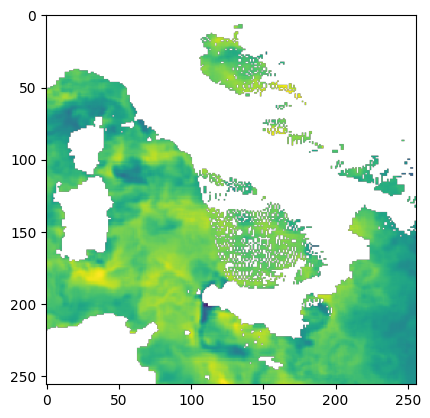

In [27]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]) #nans are blank; they could be land or clouds

**Land-sea mask**

We know the part of the territory corresponding to land.
In the land-sea mask, 1 is for sea, and 0 for land.

sea percentage =  0.5947418212890625


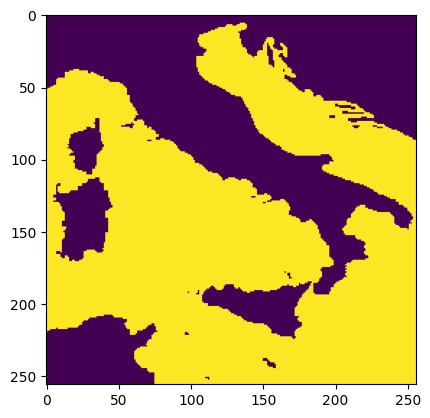

In [28]:
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(256*256))

**Statistical baseline (climatology)**

day 281
climatology min: 18.89668178747177, climatology max: 25.249772435426475


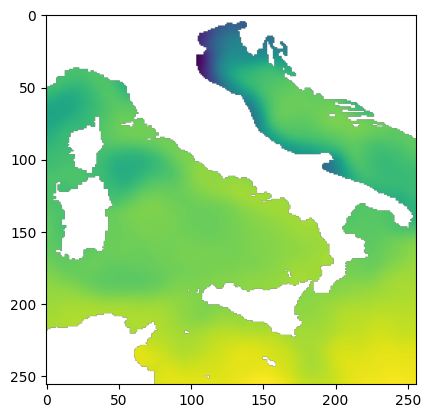

In [29]:
i = np.random.randint(0, climatology.shape[0])
print(f"day {i}")
print(f'climatology min: {np.nanmin(climatology[i])}, climatology max: {np.nanmax(climatology[i])}')
plt.imshow(climatology[0])

In [30]:
print(f"min climatology temperature: {np.nanmin(climatology)}")
print(f"max climatology temperature: {np.nanmax(climatology)}")

min climatology temperature: 7.4271409509820066
max climatology temperature: 27.903212104509006


# Generator

A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.

In [51]:
isize = 256
previous_days = 4
n_channels = 3 + 2*previous_days


def generator(batch_size, dataset, date, quadrant="O", return_days=False):
  #O for the whole dataset
  #do not return days during training
    while True:
        batch_x = np.zeros((batch_size, isize, isize, n_channels))
        batch_y = np.zeros((batch_size, isize, isize, 3))
        days = np.zeros(batch_size).astype(int)

        for b in range(batch_size):
            # Choose a random index as the current day
            found = False
            while not found:
              i = np.random.randint(previous_days, dataset.shape[0])    # Start from 4 to have at least 4 previous days
              # Ensure that the starting image has at least 40% coverage over the sea
              visible = np.sum(~np.isnan(dataset[i])/total_sea)
              if visible > 0.4:
                found = True

            days[b] = i

            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            # Extending clouds
            found = False
            while not found:
              r = np.random.randint(0, dataset.shape[0])
              mask_r = np.isnan(dataset[r])
              mask_or_r = np.logical_or(mask_current, mask_r)
              nnans = np.sum(~mask_or_r)/total_sea
              #ensure that the visible part of the sea after occlusion is
              #between 5% and 40%, with a ground truth of at least 10%
              if nnans > 0.02 and nnans < min(visible-.1,0.4):
                found = True

            # Fix artificial mask
            artificial_mask_current = np.logical_not(mask_or_r)  #1 visible, 0 masked
            # Apply the amplified mask to the current day's image
            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            # Get the previous days' images and masks
            images_prev = []
            masks_prev = []
            artificial_masks_prev = []
            images_masked_prev = []
            for j in range(previous_days):
                image_prev = np.nan_to_num(dataset[i-j-1], nan=0)
                mask_prev = np.isnan(dataset[i-j-1])
                artificia_mask_prev = ~np.logical_or(mask_prev, np.isnan(dataset[r-j-1]))
                image_masked_prev = np.where(artificia_mask_prev, image_prev, 0)

                images_prev.append(image_prev)
                masks_prev.append(mask_prev)
                artificial_masks_prev.append(artificia_mask_prev)
                images_masked_prev.append(image_masked_prev)


            # Fix masks before they are used in the loss and metric functions
            mask_current = np.logical_not(mask_current) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_mask_current, mask_current)

            # Create batch_x and batch_y
            batch_x[b, ..., 0] = image_masked_current      #artificially cloudy image
            batch_x[b, ..., 1] = artificial_mask_current   #artificial mask
            batch_x[b, ..., n_channels-1] = italy_mask     #land-sea mask
            for j in range(previous_days):
                batch_x[b, ..., (j*2)+2] = images_masked_prev[j]
                batch_x[b, ..., (j*2)+3] = artificial_masks_prev[j]


            batch_y[b, ..., 0] = image_current              #real image
            batch_y[b, ..., 1] = mask_current               #real mask
            batch_y[b, ..., 2] = diff_mask                  #'hidden' mask

        if return_days:
            yield batch_x.astype(np.float32), batch_y.astype(np.float32), days
        else:
            yield batch_x.astype(np.float32), batch_y.astype(np.float32)

In [37]:
batch_size = 32

train_gen = generator(batch_size, x_train_n, dates_train_n)
val_gen = generator(batch_size, x_val_n, dates_val_n)
test_gen = generator(batch_size, x_test_n, dates_test_n, return_days=True)

The generator returns two sets of data, called batch_x and batch_y. The idea is that batch_x data are possible inputs for the neural network, while batch_y data provide ground_truth information that can be used for defining the loss function, or auxiliary metrics. Let us inspect them in more detail.

In [38]:
import matplotlib as mpl
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

In [39]:
import matplotlib.pyplot as plt

def plot_elements_discrete(images, titles, dim=12, name="test.png"):
  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = int(np.nanmin(np.array(images)))
  maxi = int(np.nanmax(np.array(images)))
  # define the bins and normalize
  #bounds = np.linspace(mini, maxi, maxi-mini+1)
  bounds = np.linspace(mini, maxi, 2*(maxi-mini)+1)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  print(mini,maxi)

  fig,axs = plt.subplots(rows, cols,figsize=(dim, dim*num_of_images*1.3))
  for i in range(num_of_images):
    print(f"image {i}; {np.nanmin(images[i])}, {np.nanmax(images[i])}")
    #plt.imshow(images[i],vmin=mini,vmax=maxi,cmap=cmap,norm=norm)
    im = axs[i].imshow(images[i],cmap=cmap,norm=norm)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #plt.axis('off')
    axs[i].set_title(titles[i])
  fig.colorbar(im,ax=axs,shrink=0.07)
  plt.show()
  #plt.savefig(f'images/'+name)

Let us inspect a few batches

(32, 256, 256, 11)
(32, 256, 256, 3)
<class 'numpy.float32'>
16 25
image 0; 16.926265753881395, 25.877786911131672
image 1; 18.235036101765186, 25.877786911131672
image 2; 17.950351394788683, 24.547930972457053


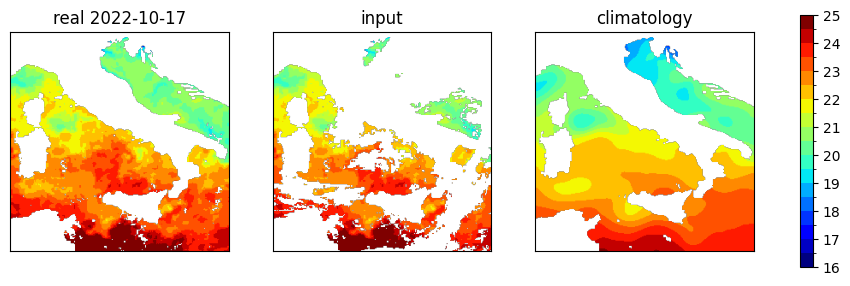

0.0 1.0
image 0; 0.0, 1.0
image 1; 0.0, 1.0
image 2; 0.0, 1.0


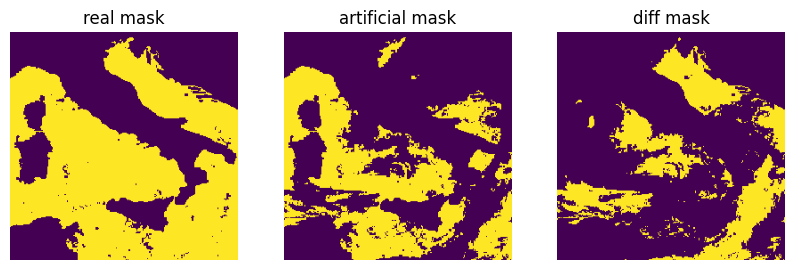

In [40]:
batch_x, batch_y, days = next(test_gen)
print(batch_x.shape)
print(batch_y.shape)
print(type(batch_y[0,0,0,0]))
dates = date_series_n[days+6940]
days_of_year = day_of_year_n[days+6940]

real_denorm = np.where(batch_y[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean + climatology[days_of_year[0]],np.nan)
artificial_denorm = np.where(batch_x[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean + climatology[days_of_year[0]],np.nan)
climatology0 = np.where(land_sea_mask,climatology[days_of_year[0]],np.nan)

#l4_batch

plot_elements_discrete([real_denorm, artificial_denorm, climatology0], ['real '+str(dates[0].date()), 'input','climatology'])
plot_elements([batch_y[0,...,1], batch_x[0,...,1], batch_y[0,...,2]],["real mask","artificial mask","diff mask"])

In the first row, we see:
- the real image of the day
- the input passed to the model, that is a masked version of the previous image
- the tentative reconstruction done via the statistical baseline
All images have been denormalized.

In the second row we see:
- the mask of the current day
- the enlarged masked with addiitonal clouds
- the difference, showing the portion of the image visible in the first one, but occluded in the second. This is the region where the performance of the model must be evaluated


# Evaluation using climatology

We evaluate the model must calling the test generator 50 times. The metrics adopted is the Rooted Mean Squared Error (RMSE).

To make a running example, we measure the performance of the climatology as a predictve model.

In [41]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y, days = next(test_gen)
    #uncomment the next line and call your model
    #predictions = model.predict(x_true, verbose=0)
    days_of_year = day_of_year_n[days+6940]
    predictions = climatology[days_of_year]

    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean + climatology[days_of_year]

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 1.0772639726816462
RMSE std : 0.5714796262920112


# unet


In [42]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Conv2DTranspose, Concatenate, concatenate, AveragePooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


def ResidualBlock(depth):
    def apply(x):
        input_depth = x.shape[3]    # Get the number of channels from the channels dimension
        if input_depth == depth:    # It's already the desired channel number
            residual = x
        else:                       # Adjust the number of channels with a 1x1 convolution
            residual = Conv2D(depth, kernel_size=1)(x)

        x = BatchNormalization(center=False, scale=False)(x)
        x = Conv2D(depth, kernel_size=3, padding="same", activation='swish')(x)
        x = Conv2D(depth, kernel_size=3, padding="same")(x)
        x = Add()([x, residual])
        return x

    return apply


def DownBlock(depth, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(depth)(x)
            skips.append(x)
        x = AveragePooling2D(pool_size=2)(x)    #downsampling
        return x

    return apply


def UpBlock(depth, block_depth):
    def apply(x):
        x, skips = x
        x = UpSampling2D(size=2, interpolation="bilinear")(x)   #upsampling
        for _ in range(block_depth):
            x = Concatenate()([x, skips.pop()])
            x = ResidualBlock(depth)(x)
        return x

    return apply


def get_Unet(image_size, depths, block_depth):
    input_images = Input(shape=image_size)  #input layer

    x = Conv2D(depths[0], kernel_size=1)(input_images)  #reduce the number of channels

    skips = []  #store the skip connections

    for depth in depths[:-1]:   #downsampling layers
        x = DownBlock(depth, block_depth)([x, skips])

    for _ in range(block_depth):    #middle layer
        x = ResidualBlock(depths[-1])(x)

    for depth in reversed(depths[:-1]):   #upsampling layers
        x = UpBlock(depth, block_depth)([x, skips])

    x = Conv2D(1, kernel_size=1, kernel_initializer="zeros", name = "output_noise")(x)  #no activation function

    return Model(input_images, outputs=x, name="UNetInpainter")


# Custom loss function (weighted MSE)
def custom_loss(y_true, y_pred):
    #y_true = tf.cast(y_true, tf.float32)

    real_mask = y_true[:,:,:,1:2]       # 0 for land/clouds, 1 for sea
    y_true = y_true[:,:,:,0:1]          # The true SST values. Obfuscated areas are already converted to 0

    # Calculate the squared error only over clear sea
    squared_error = tf.square(y_true - y_pred)
    masked_error = squared_error * real_mask

    # Calculate the mean of the masked errors
    clear_loss = tf.reduce_mean(masked_error)     # The final loss

    return clear_loss

In [43]:
# Create and compile the U-Net model
input_shape = (256, 256, n_channels)  # Input shape including the mask (4 channels)
depths = [32, 64, 128, 256]         #HYPERPARAMETER
block_depth = 2                     #HYPERPARAMETER
model_unet = get_Unet(input_shape, depths, block_depth)

# Compile the model with custom loss and Adam optimizer
adam= Adam(learning_rate=1e-4)
model_unet.compile(optimizer=adam,
                   loss=custom_loss,
                   metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae'])

# Summary of the model
model_unet.summary()

Model: "UNetInpainter"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 11)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            384 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 32)   │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 32)   │             64 │ add[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 256, 32)   │              0 │ conv2d_4[0][0],        │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 128, 128, 32)   │              0 │ add_1[0][0]            │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │             64 │ average_pooling2d[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │          2,112 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 128, 128, 64)   │              0 │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_5[0][0]         │
├──────────────────────

 Total params: 4,259,489 (16.25 MB)

 Trainable params: 4,255,777 (16.23 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [45]:
model_unet.load_weights('/content/unet256_4days_best.h5')

In [46]:
# Learning rate scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-7, verbose=1)

epochs = 0 #run for 80-100 epochs
# Training the model
history = model_unet.fit(train_gen,
                        steps_per_epoch=200,  # Adjusted based on dataset size
                        epochs=epochs,
                        validation_data=val_gen,
                        validation_steps=100,  # Adjusted based on dataset size
                        callbacks=[lr_scheduler])

In [47]:
#model_unet.save_weights('/content/unet_4d_february_2025.weights.h5')

**Warning**  executing with cpu takes time!

In [52]:
# Initialize lists to store the errors and the maximum errors
RMSE = []
test_gen = generator(batch_size, x_test_n, dates_test_n, return_days=True)
# Generate and evaluate tot batches
tot = 5
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y, days = next(test_gen)
    #uncomment the next line and call your model
    predictions = model_unet.predict(batch_x, verbose=0)[...,0]
    #predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.3126825
RMSE std : 0.11864821


# Dincae Test

In [53]:
dincae_date = np.arange(12053, 17167)   # from 2003-01-01 to 2016-12-31

Downloading Dincae test data

In [54]:
!gdown 1R80_zFBGvqlRpPW8fQ0l030YCwYG7_PJ
!gdown 1HziiOauOop7C3Ih0QmainuovlOmblEoh

Downloading...
From (original): https://drive.google.com/uc?id=1R80_zFBGvqlRpPW8fQ0l030YCwYG7_PJ
From (redirected): https://drive.google.com/uc?id=1R80_zFBGvqlRpPW8fQ0l030YCwYG7_PJ&confirm=t&uuid=4ae29c62-bd5d-4ba8-b8a8-42151289ee42
To: /content/msr_sst_t_array.npy
100% 495M/495M [00:03<00:00, 161MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HziiOauOop7C3Ih0QmainuovlOmblEoh
From (redirected): https://drive.google.com/uc?id=1HziiOauOop7C3Ih0QmainuovlOmblEoh&confirm=t&uuid=78342d31-bfab-4f4d-9ea2-57bbbeab4ed1
To: /content/msrc_sst_t_array.npy
100% 495M/495M [00:03<00:00, 152MB/s]


In [55]:
# Datasets
msr_sst_t_array = np.load('/content/msr_sst_t_array.npy')    # No added cloud data
msrc_sst_t_array = np.load('/content/msrc_sst_t_array.npy')  # Added cloud data
dincae_date = np.arange(12053, 17167)   # from 2003-01-01 to 2016-12-31
baseline_n = climatology

print(msr_sst_t_array.shape)
print(msrc_sst_t_array.shape)

data_min = np.nanmin(msr_sst_t_array, axis=(1, 2))
data_max = np.nanmax(msr_sst_t_array, axis=(1, 2))
data_min = np.nanmin(data_min)
data_max = np.nanmax(data_max)
print('data_min:', data_min, ', data_max:', data_max)

(5114, 144, 168)
(5114, 144, 168)
data_min: 2.01 , data_max: 32.475


<ipython-input-55-810533c88617>:10: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(msr_sst_t_array, axis=(1, 2))
<ipython-input-55-810533c88617>:11: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(msr_sst_t_array, axis=(1, 2))


We now define the generator from dincae data.

In [56]:
offset_y = 0
offset_x = 0  # 30 pixels are cut off from the left
end_y = 144   # since y is 144 pixels tall, all is used
end_x = 158   # the right 10 are outside

def enlarge_masks_and_images(msr_image, msr_mask, msrc_mask):
    # Create a 256x256 image and masks, and insert them in the right place
    # considering that our data is 256x256, and we overlap perfectly with the height but not with the width...
    # ...we have to pad the width by 256-158=98 pixels horizontally. The last 10 pixels are already cut off.
    greater_msr_image = np.zeros((256, 256), dtype=float)
    greater_msr_image[:144, 98:] = msr_image
    greater_msr_mask = np.ones((256, 256), dtype=bool)
    greater_msr_mask[:144, 98:] = msr_mask
    greater_msrc_mask = np.ones((256, 256), dtype=bool)
    greater_msrc_mask[:144, 98:] = msrc_mask
    return greater_msr_image, greater_msr_mask, greater_msrc_mask

#GENERATOR
def dincae_generator(batch_size, msrData, msrcData, dincae_date, italy_mask, baseline_n):
    i = previous_days
    while True:
        batch_x = np.zeros((batch_size, isize, isize, n_channels))
        batch_y = np.zeros((batch_size, isize, isize, 5))

        for b in range(batch_size):
            images = []
            masks = []
            artificial_masks = []
            image_masked = []
            for j in range(0, previous_days+1):
                date_series = pd.to_datetime(dincae_date[i-j], unit='D', origin='unix')
                day_of_year = date_series.dayofyear

                # Prepare the images and masks
                image = msrData[i-j]
                image = image[offset_y:end_y, offset_x:end_x]
                image = image - baseline_n[day_of_year-1, :144, 98:]
                image = (image - residual_n_mean) / residual_n_std
                image = np.nan_to_num(image, nan=0)

                # Prepare the masks
                msr_mask = np.isnan(msrData[i-j])
                msr_mask = msr_mask[offset_y:end_y, offset_x:end_x]

                # Prepare the artificial masks
                msrc_mask = np.isnan(msrcData[i-j])
                msrc_mask = msrc_mask[offset_y:end_y, offset_x:end_x]

                # if 256x256 the image have to be enlarged
                image, msr_mask, msrc_mask = enlarge_masks_and_images(image, msr_mask, msrc_mask)

                # Append the images and masks
                images.append(image)
                masks.append(msr_mask)
                artificial_masks.append(np.logical_not(msrc_mask))
                image_masked.append(np.where(artificial_masks[j], images[j], 0))

            # Fix masks before they are used in the loss and metric functions
            mask_current = np.logical_not(masks[0]) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_masks[0], mask_current)

          # Create batch_x and batch_y
            for j in range(0, previous_days+1):
                batch_x[b, ..., j*2] = image_masked[j]                    #artificially cloudy image
                batch_x[b, ..., j*2+1] = artificial_masks[j]              #artificial mask
            batch_x[b, ..., n_channels-1] = italy_mask                    #land-sea mask


            batch_y[b, ..., 0] = images[0]                                #real image
            batch_y[b, ..., 1] = mask_current                             #real mask
            batch_y[b, ..., 2] = diff_mask                                #artificial mask (for the metrics)
            # Increment the index
            i += 1
            if i >= msrData.shape[0]:
                i = previous_days

        yield batch_x, batch_y

dincae_gen = dincae_generator(32, msr_sst_t_array, msrc_sst_t_array, dincae_date, italy_mask, climatology)

In [57]:
# Generate and evaluate all batches in the dataset
RMSE = []
for i in range((len(msr_sst_t_array)//batch_size)+1):
    remaining_size = batch_size
    # Generate a batch
    if i < len(msr_sst_t_array) // batch_size:
        batch_x, batch_y = next(dincae_gen)
    else:
        # Special case for the last batch
        remaining_size = len(msr_sst_t_array) % batch_size
        if remaining_size == 0:
            break
        batch_x, batch_y = next(dincae_gen)

    predictions = model_unet.predict(batch_x, verbose=0)[...,0]
    predictions = predictions[:remaining_size]
    batch_y = batch_y[:remaining_size]
    batch_x = batch_x[:remaining_size]

    # Denormalize data !!!
    predictions_denorm = predictions*residual_n_std + residual_n_mean
    true_values_denorm = batch_y[..., 0]*residual_n_std + residual_n_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]     #diff mask
    #we skip masks containing too few points (less than 100), since values are unreliable
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2, axis=(1, 2))# if np.any(~np.isnan(diff_errors_batch)) else np.nan
    squared_errors = np.where(np.sum(diffMask,axis=(1,2))<100,np.nan,squared_errors)
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)
print(f"RMSE :", np.nanmean(RMSE))

<ipython-input-57-a4076594d51f>:28: RuntimeWarning: Mean of empty slice
  squared_errors = np.nanmean(diff_errors_batch**2, axis=(1, 2))# if np.any(~np.isnan(diff_errors_batch)) else np.nan


RMSE : 0.47272318023721244
